# 📊 Análise Fatorial (PCA) aplicada a Indicadores Ambientais de  Distritos da Cidade de São Paulo

## 📌 Contexto do Estudo

Neste notebook, aplicamos Análise Fatorial baseada em Componentes Principais (PCA) com o objetivo de reduzir a dimensionalidade de um conjunto de indicadores ambientais e socioeconômicos dos distritos da cidade de São Paulo.
A PCA permite identificar fatores latentes que sintetizam múltiplas variáveis correlacionadas, facilitando a interpretação dos dados e sua posterior análise espacial por meio de mapas temáticos.

## Resumo


Neste projeto, apliquei Análise Fatorial por Componentes Principais (PCA) a um conjunto de indicadores ambientais dos distritos do município de São Paulo, com o objetivo de identificar dimensões latentes capazes de sintetizar padrões complexos presentes nos dados.

A análise exploratória inicial, por meio da matriz de correlação e do Teste de Esfericidade de Bartlett, evidenciou correlações estatisticamente significativas entre as variáveis, confirmando a adequação do uso da PCA. Com base no critério de Kaiser, foram extraídos dois fatores principais, responsáveis por explicar uma parcela relevante da variância total do conjunto de dados.

As cargas fatoriais e o loading plot permitiram interpretar os fatores como combinações estruturais dos indicadores ambientais, enquanto as comunalidades indicaram boa retenção de informação após a redução de dimensionalidade. A extração dos scores fatoriais possibilitou a construção de um indicador sintético, representado pelo primeiro fator, utilizado como proxy de desempenho socioambiental dos distritos.

Esse indicador foi posteriormente integrado a dados geoespaciais, permitindo a visualização espacial dos resultados por meio de um mapa temático. O mapa evidencia a heterogeneidade intraurbana entre os distritos, destacando padrões espaciais relevantes que não seriam facilmente identificados a partir da análise isolada das variáveis originais.

O projeto demonstra como técnicas estatísticas multivariadas podem ser combinadas com visualização geográfica para transformar dados ambientais complexos em informações interpretáveis, apoiando diagnósticos territoriais, análise exploratória e tomada de decisão baseada em dados.

# 📦 Importação das Bibliotecas

## O que estamos fazendo aqui?

Nesta etapa, importamos todas as bibliotecas necessárias ao longo do notebook.
Cada biblioteca tem um papel específico, como:
*   pandas e numpy: manipulação e análise de dados;
*   factor_analyzer: execução da PCA;
*   matplotlib, seaborn e plotly: visualizações;
*   pyshp: leitura de arquivos shapefile;
*   Também desativamos avisos para manter a saída do notebook mais limpa.

In [ ]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.graph_objects as go
import shapefile as shp
import warnings
warnings.filterwarnings("ignore")

## 📥 Importação da Base de Dados

Carregamos o banco de dados contendo os indicadores ambientais e socioeconômicos dos distritos de São Paulo.
Essa etapa é fundamental para:
*   Entender a estrutura do conjunto de dados;
*   Identificar variáveis categóricas e numéricas;
*   Planejar corretamente a aplicação da PCA

## 🔎 Inspeção Inicial dos Dados

*   Antes de aplicar qualquer técnica estatística, é essencial:
*   Verificar tipos de dados
*   Identificar valores ausentes
*   Avaliar a escala das variáveis

Essas informações ajudam a evitar erros metodológicos e garantem que a PCA seja aplicada corretamente.

## 📊 Estatísticas Descritivas

Por que analisar estatísticas básicas?

*   As estatísticas descritivas permitem:
*   Compreender a distribuição das variáveis
*   Identificar possíveis outliers
*   Avaliar a necessidade de padronização

Nesta etapa, removemos identificadores que não devem entrar na PCA.

In [ ]:
atlas = pd.read_excel("atlas_ambiental.xlsx")
print(atlas.info())

# Estatísticas descritiva das variáveis

atlas.drop(columns=['cód_ibge']).describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cód_ibge      96 non-null     int64  
 1   distritos     96 non-null     object 
 2   renda         96 non-null     int64  
 3   quota         96 non-null     float64
 4   escolaridade  96 non-null     float64
 5   idade         96 non-null     int64  
 6   mortalidade   96 non-null     float64
 7   txcresc       96 non-null     float64
 8   causasext     96 non-null     float64
 9   favel         96 non-null     float64
 10  denspop       96 non-null     float64
dtypes: float64(7), int64(3), object(1)
memory usage: 8.4+ KB
None


,renda,quota,escolaridade,idade,mortalidade,txcresc,causasext,favel,denspop
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1856.218750,30.478021,7.075000,27.395833,15.992812,0.041146,71.086667,5.932187,99.860104
std,970.774441,23.040243,1.008908,4.385332,4.994409,3.509652,23.315169,7.883762,49.606814
min,159.000000,0.610000,4.800000,20.000000,6.460000,-6.240000,22.680000,0.000000,0.370000
25%,1150.000000,12.400000,6.300000,23.000000,12.960000,-2.042500,56.417499,0.000000,64.317497
50%,1628.000000,24.304999,7.000000,27.000000,16.230000,-0.835000,70.395000,3.015000,96.165001
75%,2315.500000,40.989999,7.850000,31.000000,18.720001,1.342500,82.370001,7.837500,136.222500
max,5146.000000,104.730003,9.200000,36.000000,44.250000,18.120001,127.370003,45.689999,249.600006


## 🧮 Seleção das Variáveis para a PCA

A PCA exige variáveis numéricas e contínuas.
Variáveis categóricas ou identificadores (como códigos e nomes) não contribuem para a análise fatorial e devem ser excluídas.
Aqui, criamos um novo DataFrame contendo apenas as variáveis adequadas para a PCA.

## 🔗 Matriz de Correlação
Por que analisar correlação antes da PCA?

A PCA é mais eficaz quando as variáveis apresentam correlação entre si.
A matriz de correlação permite:

*   Identificar multicolinearidade
*   Avaliar se a PCA é apropriada
*   Antecipar possíveis agrupamentos de variáveis

In [ ]:
#Separando somente as variáveis quantitativas do banco de dados

atlas_pca = atlas.drop(columns=['cód_ibge', 'distritos'])

#Matriz de correlações entre as variáveis

corr = atlas_pca.corr()

# Gráfico interativo

fig = go.Figure()

fig.add_trace(
    go.Heatmap(
        x = corr.columns,
        y = corr.index,
        z = np.array(corr),
        text = corr.values,
        texttemplate = '%{text:.2f}',
        colorscale = 'viridis'))

fig.update_layout(
    height = 600,
    width = 600,
    yaxis = dict(autorange='reversed'),
    title = {'text':'Matriz de Correlações', 'x':0.50})
fig.show()

## 🧪 Teste de Esfericidade de Bartlett

O teste de Bartlett avalia se a matriz de correlação é significativamente diferente de uma matriz identidade.

*   Hipótese nula (H₀): as variáveis não são correlacionadas.

*  Se H₀ for rejeitada: há correlação significativa entre as variáveis, indicando que a aplicação da PCA (ou Análise Fatorial) é adequada.

**Aqui no caso como o resultado foi de p-valor: 0.0 então rejeitamos a Hipótese nula**

In [ ]:
#Teste de Esfericidade de Bartlett

bartlett, p_value = calculate_bartlett_sphericity(atlas_pca)

print(f'Qui² Bartlett: {round(bartlett, 2)}')
print(f'p-valor: {round(p_value, 4)}')

Qui² Bartlett: 748.16
p-valor: 0.0


## 🧠 Extração Inicial dos Componentes Principais

Nesta etapa inicial:

*   Extraímos todos os fatores possíveis
*   Analisamos os autovalores (eigenvalues)
*   Avaliamos quanta variância cada componente explica

Isso nos ajuda a decidir quantos fatores devem ser retidos.

## 📐 Definição do Número de Fatores

Utilizei o Critério de Kaiser, que recomenda a retenção de fatores com autovalores maiores que 1.

**Com base nesse critério, defini o número final de fatores a serem extraídos na PCA como 2.**

In [ ]:
#Definindo a PCA (procedimento inicial com todos os fatores possíveis)

fa = FactorAnalyzer(n_factors=9, method='principal', rotation=None).fit(atlas_pca)

#Obtendo os eigenvalues (autovalores)

autovalores = fa.get_eigenvalues()[0]

print(autovalores)

[4.95603069 1.16433814 0.99635412 0.72406663 0.52930223 0.39832415
 0.12966871 0.06506649 0.03684884]


## 📈 Variância Explicada pelos Fatores

A análise da variância explicada permite:

*   Avaliar a eficiência da redução de dimensionalidade
*   Justificar estatisticamente o modelo
*   Comunicar resultados de forma clara

O gráfico de barras ajuda a visualizar a contribuição de cada fator.

**O primeiro fator representa 55,07% de variância das variáveis, enquanto o segundo fator representa apenas 12,94%**

         Autovalor  Variância  Variância Acumulada
Fator 1   4.956031   0.550670             0.550670
Fator 2   1.164338   0.129371             0.680041


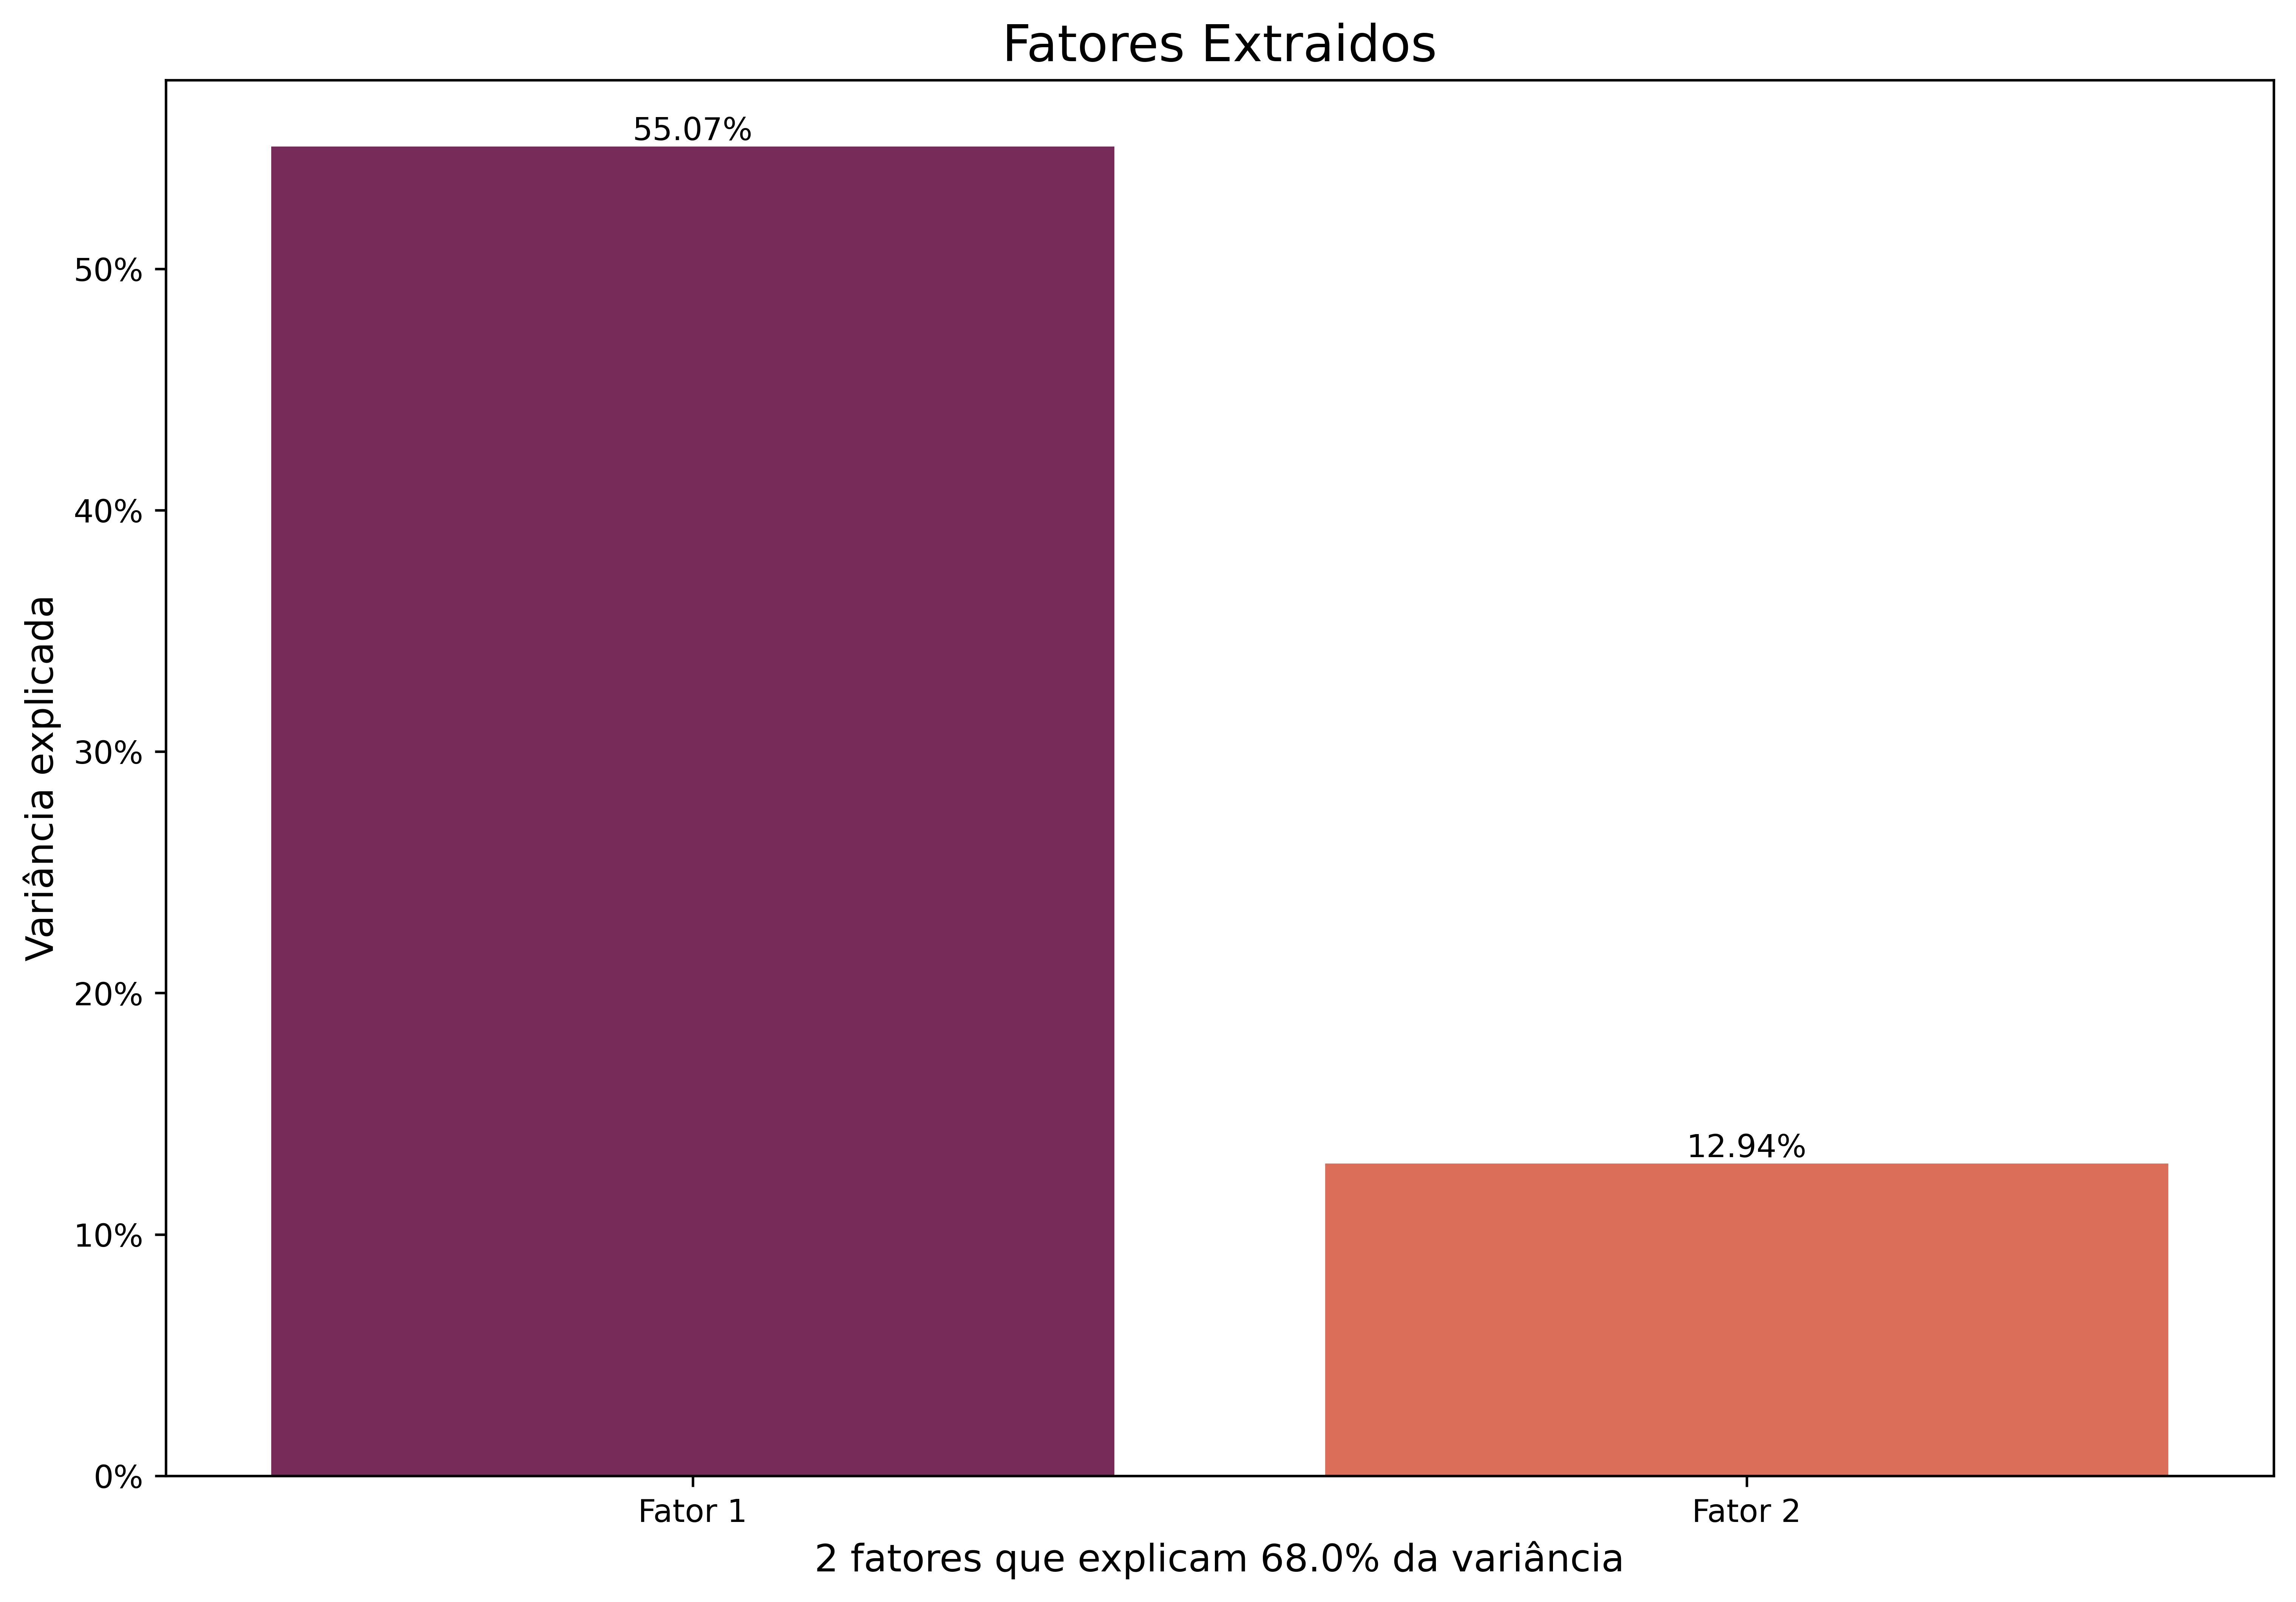

In [ ]:
# Parametrizando a PCA para os fatores derivados de autovalores > 1

fa = FactorAnalyzer(n_factors=2, method='principal', rotation=None).fit(atlas_pca)

# Eigenvalues, variâncias e variâncias acumuladas

autovalores_fatores = fa.get_factor_variance()

tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

print(tabela_eigen)
# Gráfico da variância acumulada dos componentes principais

plt.figure(figsize=(12,8), dpi=600)
ax = sns.barplot(x=tabela_eigen.index, y=tabela_eigen['Variância'], hue=tabela_eigen.index, palette='rocket', data=tabela_eigen)
for container in ax.containers:
    labels = [f"{v*100:.2f}%" for v in container.datavalues]
    ax.bar_label(container, labels=labels)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))
plt.title("Fatores Extraidos", fontsize=16)
plt.xlabel(f"{tabela_eigen.shape[0]} fatores que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=12)
plt.ylabel("Variância explicada", fontsize=12)
plt.show()

## 🧩 Cargas Fatoriais

As cargas fatoriais representam:

*   O grau de associação entre cada variável e cada fator
*   A base para interpretação conceitual dos fatores

Aqui analisei quais variáveis mais contribuem para cada componente.

### 📍 Loading Plot (Fator 1 × Fator 2)

O loading plot facilita:

*   A visualização conjunta das cargas fatoriais
*   A identificação de agrupamentos de variáveis
*   A interpretação geométrica dos fatores

               Fator 1   Fator 2
renda         0.832127  0.368971
quota         0.900606  0.226453
escolaridade  0.966543 -0.024594
idade         0.960135 -0.065447
mortalidade  -0.655699 -0.176634
txcresc      -0.696781  0.337446
causasext    -0.666578 -0.043910
favel        -0.457185  0.442840
denspop       0.166281 -0.793048


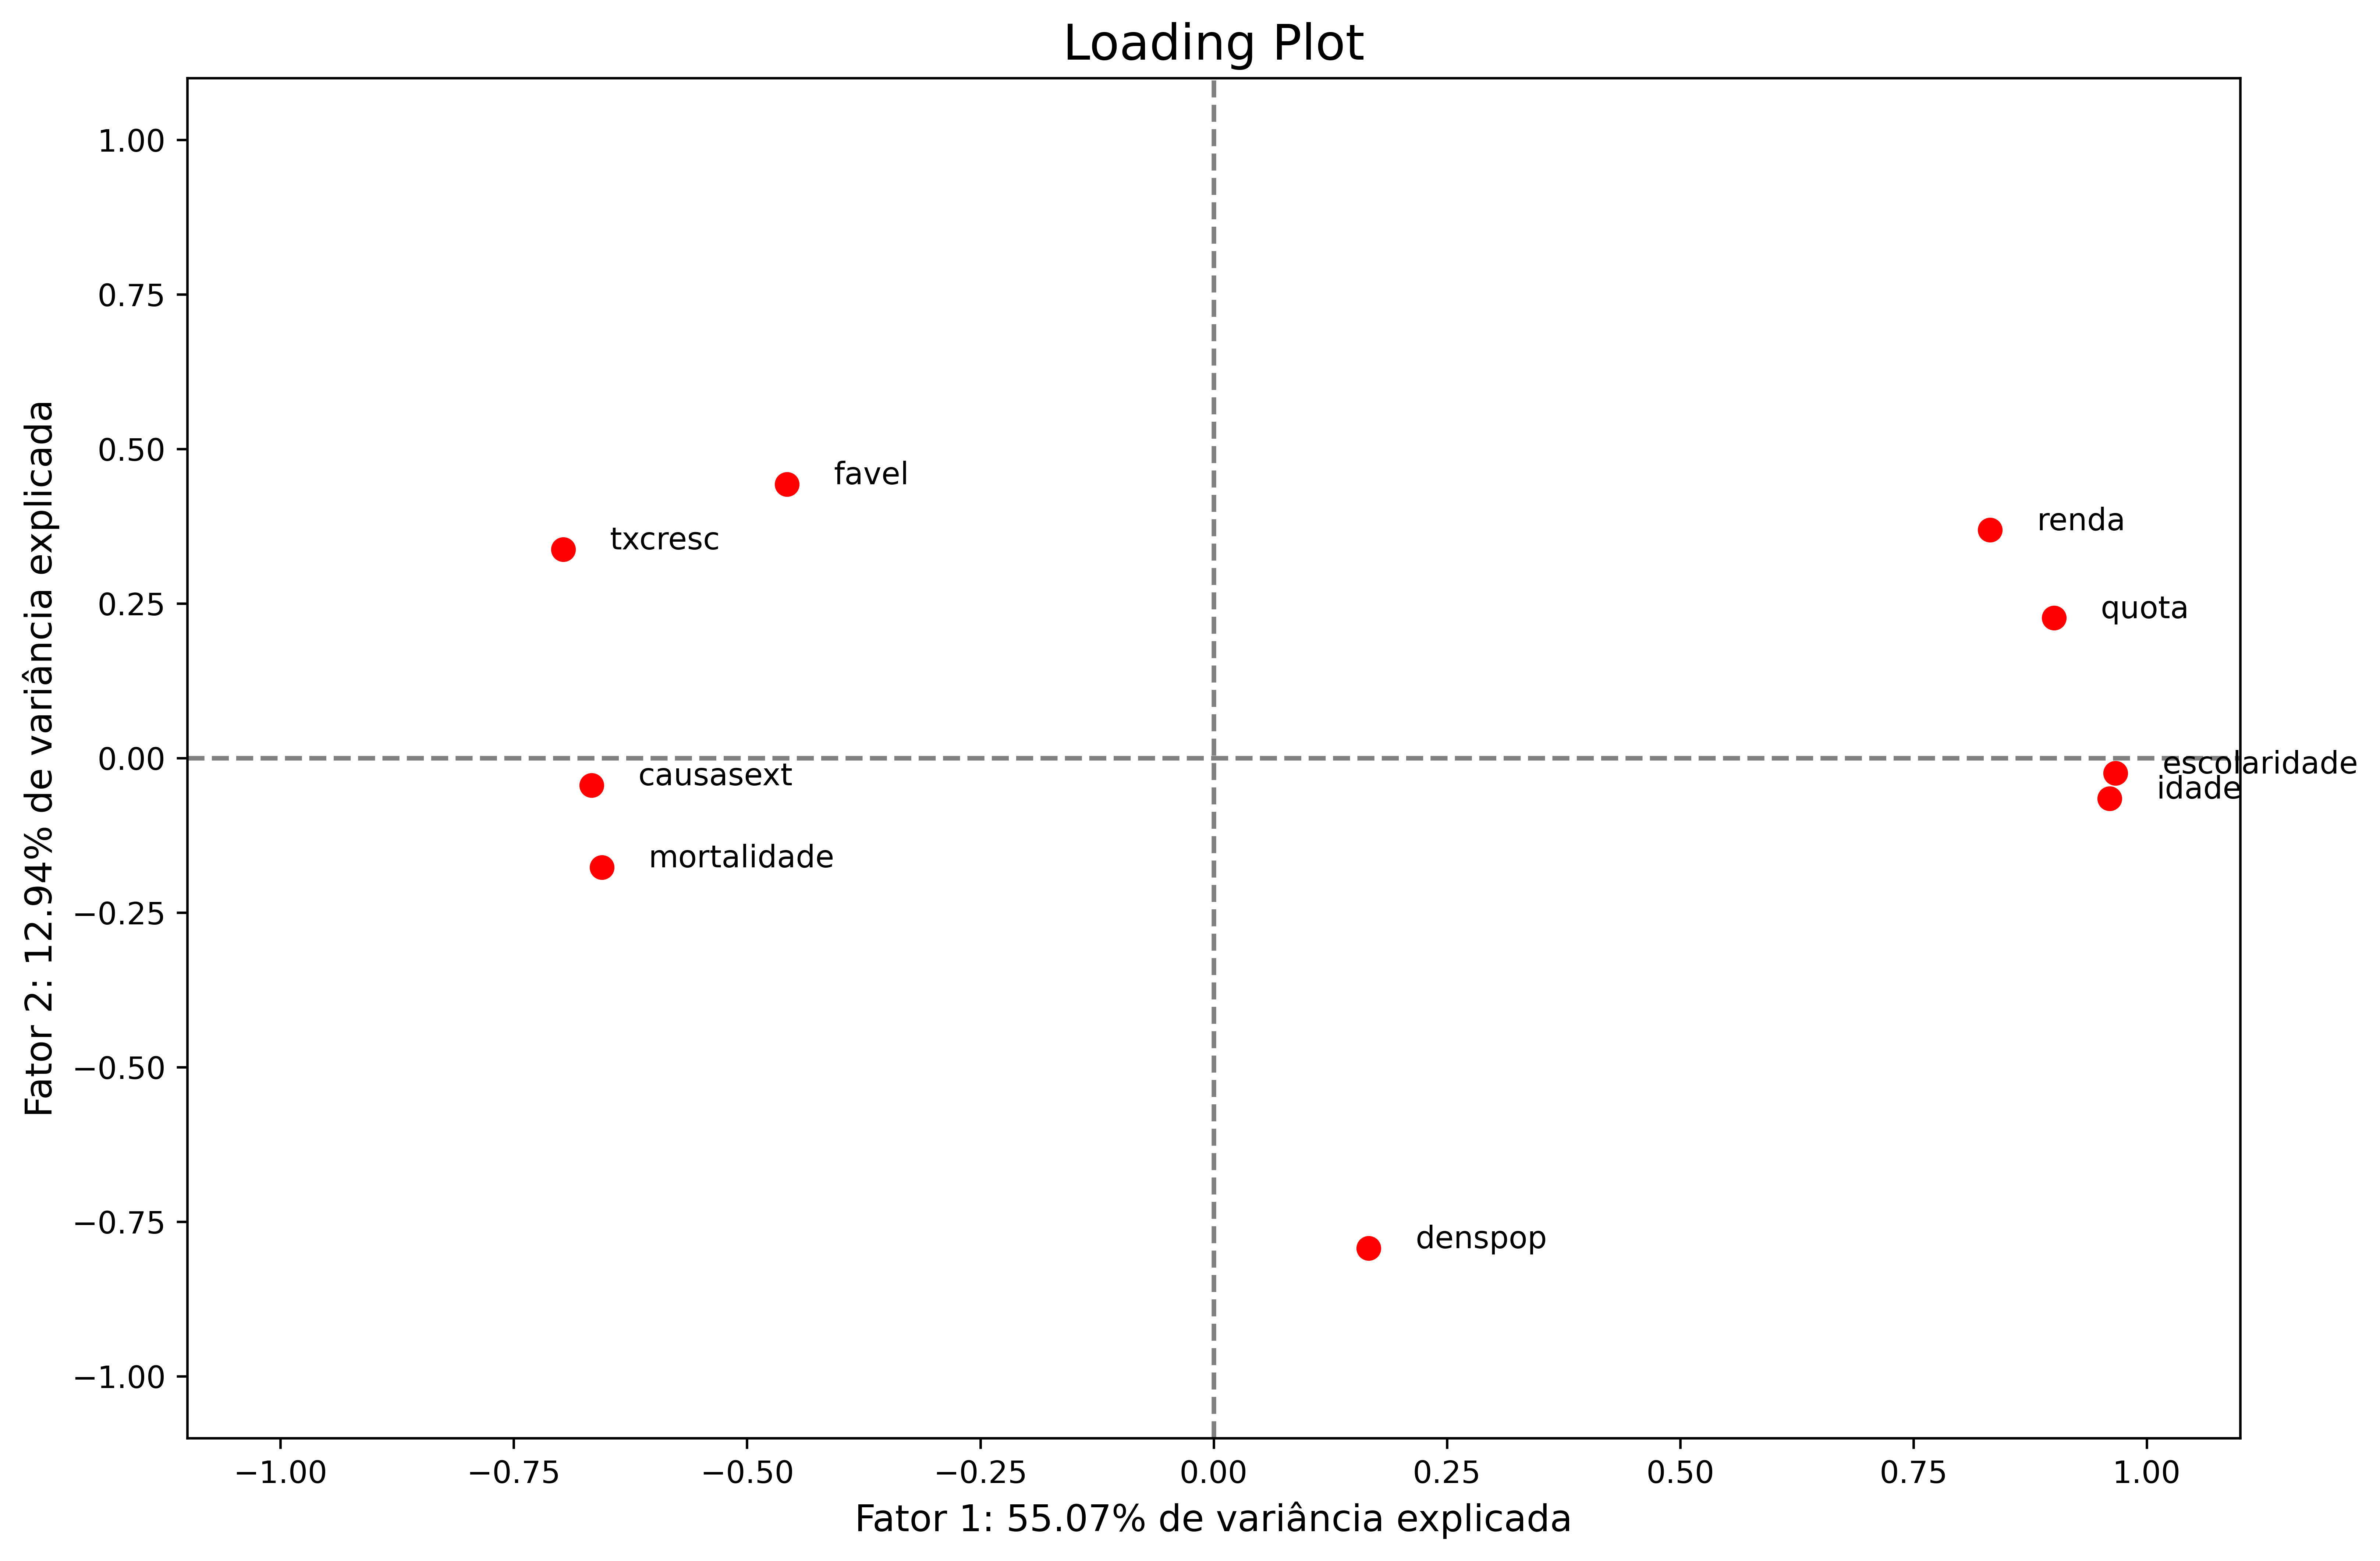

In [ ]:
#Determinando as cargas fatoriais

cargas_fatoriais = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatoriais)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = atlas_pca.columns

print(tabela_cargas)

#Gráfico das cargas fatoriais (loading plot)

plt.figure(figsize=(12,8), dpi=600)
tabela_cargas_chart = tabela_cargas.reset_index()
plt.scatter(tabela_cargas_chart['Fator 1'], tabela_cargas_chart['Fator 2'], s=50, color='red')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.05, point['y'], point['val'])

label_point(x = tabela_cargas_chart['Fator 1'],
            y = tabela_cargas_chart['Fator 2'],
            val = tabela_cargas_chart['index'],
            ax = plt.gca())

plt.axhline(y=0, color='grey', ls='--')
plt.axvline(x=0, color='grey', ls='--')
plt.ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.title("Loading Plot", fontsize=16)
plt.xlabel(f"Fator 1: {round(tabela_eigen.iloc[0]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.ylabel(f"Fator 2: {round(tabela_eigen.iloc[1]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.show()

## 🔁 Comunalidades

As comunalidades indicam:
*   Quanto da variância de cada variável foi preservada
*   A qualidade da representação fatorial
*   Valores elevados indicam boa explicação pelos fatores extraídos.

**Foi possivel avaliar que 3 variáveis estavam sendo representadas abaixo de 50% tendo baixas variações.**

In [ ]:
#Determinando as comunalidades

comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = atlas_pca.columns

print(tabela_comunalidades)

              Comunalidades
renda              0.828575
quota              0.862372
escolaridade       0.934811
idade              0.926143
mortalidade        0.461141
txcresc            0.599374
causasext          0.446254
favel              0.405126
denspop            0.656574


In [ ]:
#Extração dos fatores para as observações do banco de dados

fatores = pd.DataFrame(fa.transform(atlas_pca))
fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(fatores.columns)]

#Adicionando os fatores ao banco de dados

atlas = pd.concat([atlas.reset_index(drop=True), fatores], axis=1)
atlas

,cód_ibge,distritos,renda,quota,escolaridade,idade,mortalidade,txcresc,causasext,favel,denspop,Fator 1,Fator 2
0,1,Água Rasa,1961,34.619999,7.6,32,13.86,-1.840000,52.980000,0.00,125.610001,0.682371,-0.705531
1,2,Alto de Pinheiros,4180,75.959999,8.4,33,8.68,-2.520000,38.570000,0.69,57.560001,1.790304,1.441565
2,3,Anhanguera,1093,4.500000,5.8,23,15.36,18.120001,22.680000,0.00,8.570000,-1.204379,2.183685
3,4,Aricanduva,1311,21.020000,6.8,27,18.43,-1.070000,76.220001,5.38,138.539993,-0.257928,-0.983935
4,5,Artur Alvim,1248,15.910000,7.0,27,19.73,-1.400000,67.250000,4.11,167.399994,-0.205284,-1.564607
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,92,Vila Medeiros,1405,19.760000,6.8,27,15.43,-1.410000,77.980003,2.49,188.929993,-0.099947,-1.738918
92,93,Vila Prudente,1755,32.080002,7.2,30,14.36,-2.550000,66.510002,7.43,101.440002,0.292861,-0.162769
93,94,Vila Sônia,2970,41.410000,7.4,27,16.76,-0.900000,74.680000,14.93,80.120003,0.203269,1.057936
94,95,São Domingos,2047,23.510000,6.8,26,14.30,0.710000,62.349998,8.55,72.919998,-0.117800,0.647456


## Qual a utilidade dos scores?

Os scores fatoriais:

*   Representam cada distrito nos eixos latentes
*   Permitem criar rankings e análises comparativas
*   São usados como base para análise espacial

In [ ]:
#Identificando os scores fatoriais

scores = fa.weights_

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = atlas_pca.columns

print(tabela_scores)

               Fator 1   Fator 2
renda         0.167902  0.316893
quota         0.181719  0.194491
escolaridade  0.195024 -0.021122
idade         0.193731 -0.056210
mortalidade  -0.132303 -0.151703
txcresc      -0.140593  0.289818
causasext    -0.134498 -0.037712
favel        -0.092248  0.380336
denspop       0.033551 -0.681115


## 📊 Construção do Indicador Sintético
Por que usar apenas o primeiro fator?

O primeiro fator geralmente:
*   Explica a maior parte da variância
*   Representa o eixo mais relevante do fenômeno estudado

**Neste projeto, ele foi adotado como indicador socioeconômico/ambiental sintético. Mas existe a possibilidade de fazer uma soma ponderada entre os dois fatores caso fosse necessário.**


In [ ]:
#Considere que o primeiro fator seja adequado para o ranking de distritos

# Note que adotamos um critério distinto da "soma ponderada"

dados_mapa = atlas[['cód_ibge', 'distritos', 'Fator 1']].sort_values(by=['cód_ibge'], ascending = True).reset_index(drop=True)

#Importando o mapa da cidade de São Paulo

sf = shp.Reader("DEINFO_DISTRITO")

def read_shapefile(sf):
    fields = [x[0] for x in sf.fields][1:]
    records = [y[:] for y in sf.records()]
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

dist = read_shapefile(sf)

## 🗺️ Integração com Dados Espaciais

Aqui integramos:

1.   Os scores fatoriais

2.   O shapefile dos distritos de São Paulo

Isso permite representar os resultados da PCA diretamente no território.

## 🎨 Classificação e Mapa Temático
Como o mapa é construído?

*   Os valores do fator são divididos em 6 faixas (quantis)
*   Cada faixa recebe uma tonalidade de cor
*   O resultado é um mapa coroplético interpretável e informativo

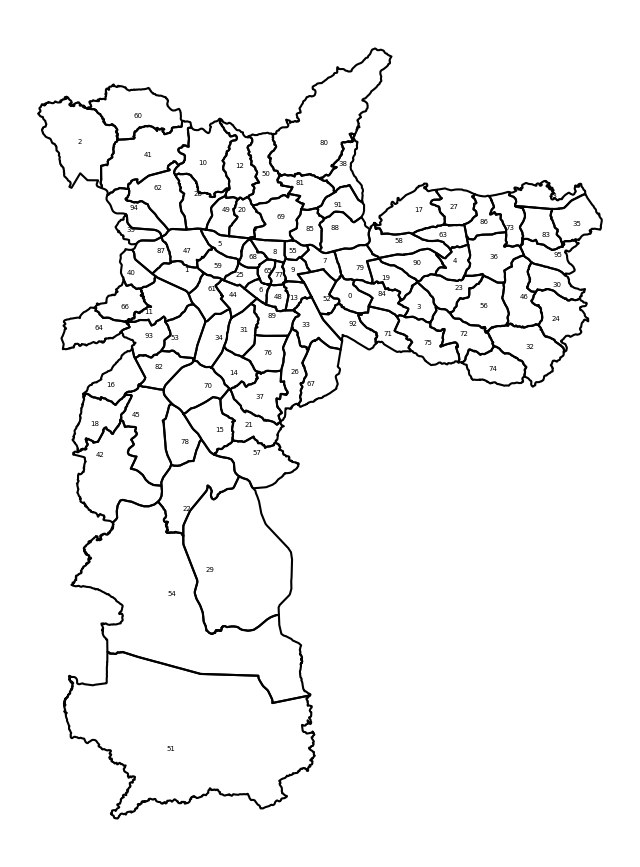

In [ ]:
# Organizando o banco de dados das coordenadas

dist['COD_DIST'] = pd.to_numeric(dist['COD_DIST'])
dist = dist.sort_values(by=['COD_DIST'], ascending = True).reset_index(drop=True)

# Gerando o mapa da cidade de SP com distritos delimitados

def plot_map(df, x_lim = None, y_lim = None, figsize = (8,11)):

    plt.figure(figsize = figsize)
    id=0
    for coordinates in df.coords:
        x = [i[0] for i in coordinates]
        y = [i[1] for i in coordinates]
        plt.plot(x, y, 'k')

        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=5, ha='center', va='center')
        id = id+1

    if (x_lim != None) & (y_lim != None):
        plt.xlim(x_lim)
        plt.ylim(y_lim)

    plt.axis('off')

plot_map(dist)

<Figure size 800x1100 with 0 Axes>

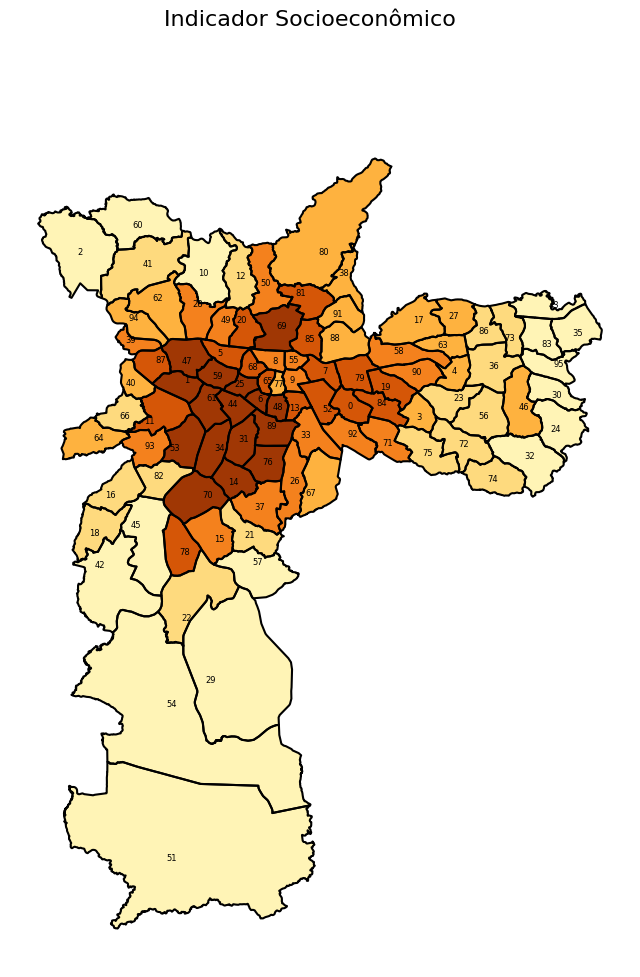

In [ ]:
# Definindo as cores

# Vamos dividir os valores do fator em 6 faixas

def calc_color(data):
        new_data = pd.qcut(data, 6, labels=list(range(6)))
        paleta = sns.color_palette('YlOrBr', n_colors=6)
        color_sq = paleta.as_hex()
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val])
        return color_ton

#Plotando o mapa com as cores

def plot_map_fill_multiples_ids_3(df, title, distrito_id, color_ton, x_lim = None, y_lim = None, figsize = (8,11)):

    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)

    for coordinates in df.coords:
        x = [i[0] for i in coordinates]
        y = [i[1] for i in coordinates]
        plt.plot(x, y, 'k')

    for id in distrito_id:
        shape_ex = df.coords[id]
        x_lon = np.zeros((len(shape_ex),1))
        y_lat = np.zeros((len(shape_ex),1))
        for ip in range(len(shape_ex)):
            x_lon[ip] = shape_ex[ip][0]
            y_lat[ip] = shape_ex[ip][1]
        ax.fill(x_lon,y_lat,  color_ton[distrito_id.index(id)]);
        x0 = np.mean(x_lon)
        y0 = np.mean(y_lat)
        plt.text(x0, y0, id, fontsize=6, ha='center', va='center')

    if (x_lim != None) & (y_lim != None):
        plt.xlim(x_lim)
        plt.ylim(y_lim)

    plt.axis('off')

distritos = list(np.arange(96)) # id_distritos
data = list(dados_mapa['Fator 1']) # indicador socioeconômico (fator)
color_ton = calc_color(data) # tonalidade de cores
plot_map_fill_multiples_ids_3(dist, 'Indicador Socioeconômico', distritos, color_ton)


## ✅ Resultado e Conclusão

O mapa temático construído a partir do primeiro fator da Análise de Componentes Principais evidencia um padrão espacial claro entre os distritos do município de São Paulo. Observa-se que as tonalidades mais escuras, que representam valores mais elevados do indicador socioambiental sintético, concentram-se predominantemente na região mais central da cidade. Esse resultado indica a presença de melhores condições relativas associadas às variáveis que compõem o fator nas áreas centrais, em contraste com distritos periféricos, que apresentam tonalidades mais claras e, consequentemente, menores valores do indicador.

A concentração de cores mais intensas na região central sugere a existência de desigualdades espaciais marcantes, revelando um gradiente territorial consistente entre centro e periferia. Esse padrão reforça a capacidade da PCA em sintetizar múltiplos indicadores ambientais em uma métrica única e interpretável, além de demonstrar o potencial da visualização geoespacial para identificar assimetrias territoriais que não seriam facilmente percebidas por meio de análises tabulares ou univariadas.

## ✅ Considerações Finais

Este notebook demonstra como técnicas de estatística multivariada podem ser integradas a análises geoespaciais, gerando indicadores sintéticos úteis para:

1.   Planejamento urbano
2.   Análise territorial
3.   Apoio à tomada de decisão pública